In [1]:
### set up the notebook
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=100) 

plt.rcParams.update({'font.size': 14})

In [2]:
def remove_outliers_IQR(data, limit):
    len_nan = len(data[np.isnan(data)])
    q1 = np.nanpercentile(data, 25)
    q3 = np.nanpercentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - limit * iqr
    upper_bound = q3 + limit * iqr
    # where data is outside bounds, replace with nan
    data_cp = data.copy()
    data_cp[(data_cp < lower_bound) | (data_cp > upper_bound)] = np.nan
    print('Removed %d / %d points' % (np.sum(np.isnan(data_cp))-len_nan, len(data.flatten())))
    return data_cp

In [3]:
# load the SWOT and GNSS buoy data

swot = xr.open_mfdataset('./data/SWOT_products_at_buoys.nc')
buoy = xr.open_dataset('./data/GNSS_at_SWOT_times.nc')

# create swot time array
swot_time = buoy.time.values

In [4]:
### apply corrections to SWOT SSH to make it comparable to buoys (solid earth, SE of pole tide, ocean tidal loading)

h2 = 0.6207
k2 = 0.302
pole_factor = h2 / (1 + k2)

swot['ssh_comparison'] = swot.PGC_ssh_karin_2 - swot.PGC_solid_earth_tide - swot.PGC_load_tide_fes - swot.PGC_pole_tide * pole_factor

# apply quality flag, preserving points at buoy closest to the coast which would otherwise be discarded
swot['ssh_comparison'] = swot['ssh_comparison'].where(swot.PGC_ssh_karin_2_qual < 257)

# apply quality flag to PGC0 corrections
swot['PGC_height_cor_xover'] = swot['PGC_height_cor_xover'].where(swot.PGC_height_cor_xover_qual < 1)
swot['ssh_comparison'] = swot.PGC_height_cor_xover.values + swot.ssh_comparison


# # apply quality flag to buoy
buoy['ssh'] = buoy['ssh'].where(buoy.ssh_quality <2)

In [5]:
### calculate residuals and remove outliers

buoy['ssh_resid'] = swot.ssh_comparison.values - buoy.ssh

ssh_resid_clean = buoy.ssh_resid.values

for i in range(9):
    ssh_resid_clean[i,:] = remove_outliers_IQR(buoy.ssh_resid.values[i,:], 1.5)

Removed 1 / 96 points
Removed 2 / 96 points
Removed 1 / 96 points
Removed 1 / 96 points
Removed 2 / 96 points
Removed 1 / 96 points
Removed 2 / 96 points
Removed 3 / 96 points
Removed 10 / 96 points


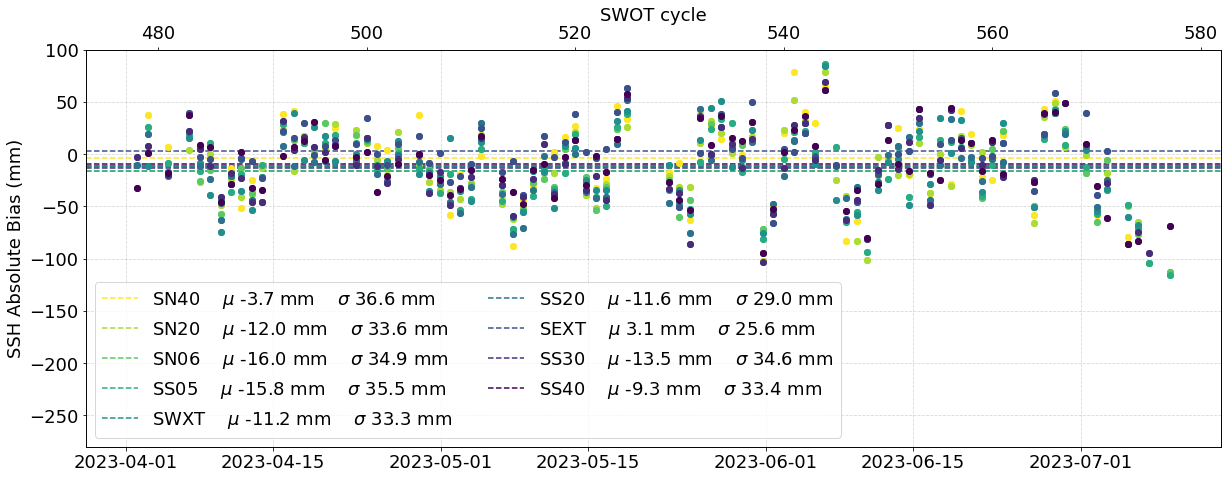

In [6]:
### plot

# reorder array based on latitude
reorder = np.array((0,1,2,3,7,4,8,5,6))
# make array for line colors
line_cols = plt.cm.viridis_r(np.linspace(0, 1, 9))

fig_width = 17.4
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(1, figsize=(fig_width,7))
axes = [ax, ax.twiny()]
for j in range(9):
    i = reorder[j]
    ax.scatter(buoy.time, ssh_resid_clean[i,:]*1000, color=line_cols[j])
    axes[1].scatter(buoy.swot_cycle, ssh_resid_clean[i,:]*1000, color=line_cols[j])    
    ax.axhline(y=np.nanmean(ssh_resid_clean[i,:]*1000), linestyle='--', c=line_cols[j], label=("%s    $\mu$ %0.1f mm    $\sigma$ %0.1f mm" % (buoy.site.values[i], np.nanmean(ssh_resid_clean[i,:])*1000, np.nanstd(ssh_resid_clean[i,:])*1000)))
ax.legend(ncol=2)
ax.grid(ls='--', alpha=0.5)
ax.set_ylabel('SSH Absolute Bias (mm)')
axes[1].set_xlabel('SWOT cycle')
ax.set_ylim(-280,100)

plt.tight_layout()
plt.show()

In [7]:
### print statistics

ssh_resid_combined = buoy.ssh_resid.values.flatten()
ssh_resid_combined_clean = remove_outliers_IQR(ssh_resid_combined, 1.5)

print('mean: %0.1f mm' % (np.nanmean(ssh_resid_combined_clean)*1000))
print('stdev: %0.1f mm' % (np.nanstd(ssh_resid_combined_clean)*1000))
print('RMSE: %0.1f mm' % (np.sqrt(np.nanmean(ssh_resid_combined_clean**2))*1000))

Removed 3 / 864 points
mean: -9.9 mm
stdev: 33.0 mm
RMSE: 34.5 mm


In [9]:
#### repeat for PIB

swot['ssh_comparison_PIB'] = swot.PIB_ssh_karin_2 - swot.PGC_solid_earth_tide - swot.PGC_load_tide_fes - swot.PGC_pole_tide * pole_factor

# apply quality flag, preserving points at buoy closest to the coast which would otherwise be discarded
swot['ssh_comparison_PIB'] = swot['ssh_comparison_PIB'].where(swot.PIB_ssh_karin_2_qual < 257)
swot['ssh_comparison_PIB'] = swot.PIB_height_cor_xover.values + swot.ssh_comparison_PIB

buoy['ssh_resid_PIB'] = swot.ssh_comparison_PIB.values - buoy.ssh
ssh_resid_clean_PIB = buoy.ssh_resid_PIB.values

for i in range(9):
    ssh_resid_clean_PIB[i,:] = remove_outliers_IQR(buoy.ssh_resid_PIB.values[i,:], 1.5)

Removed 1 / 96 points
Removed 2 / 96 points
Removed 0 / 96 points
Removed 1 / 96 points
Removed 1 / 96 points
Removed 1 / 96 points
Removed 1 / 96 points
Removed 1 / 96 points
Removed 2 / 96 points


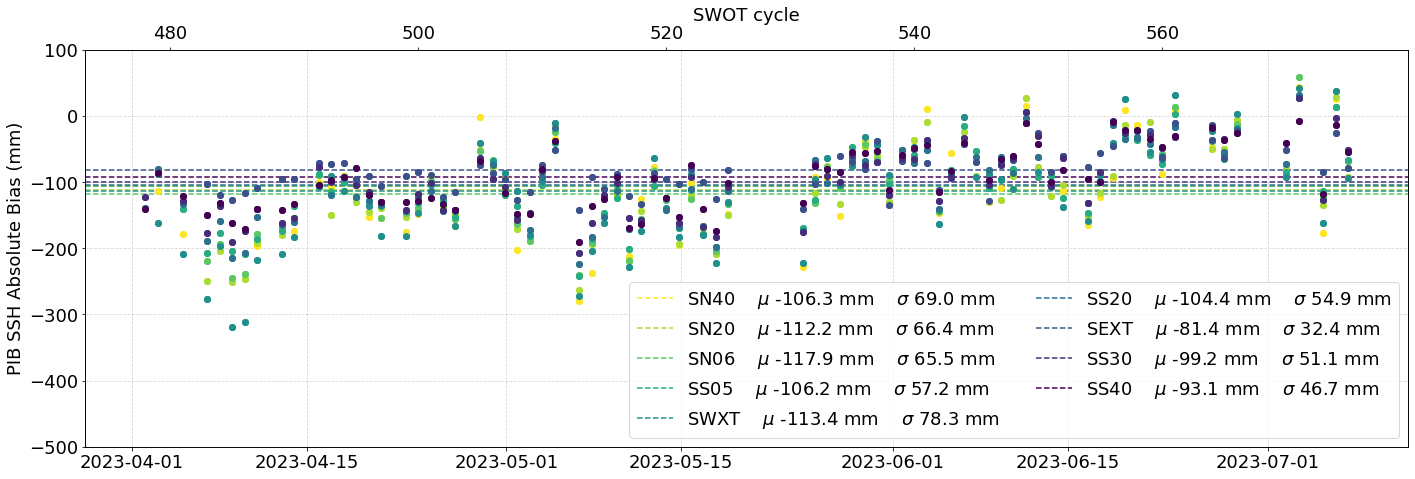

In [11]:
### plot PIB

fig, ax = plt.subplots(1, figsize=(20,7))
axes = [ax, ax.twiny()]
for j in range(9):
    i = reorder[j]
    ax.scatter(buoy.time, ssh_resid_clean_PIB[i,:]*1000, color=line_cols[j])
    axes[1].scatter(buoy.swot_cycle, ssh_resid_clean_PIB[i,:]*1000, color=line_cols[j])    
    ax.axhline(y=np.nanmean(ssh_resid_clean_PIB[i,:]*1000), linestyle='--', c=line_cols[j], label=("%s    $\mu$ %0.1f mm    $\sigma$ %0.1f mm" % (buoy.site.values[i], np.nanmean(ssh_resid_clean_PIB[i,:])*1000, np.nanstd(ssh_resid_clean_PIB[i,:])*1000)))
ax.legend(ncol=2)#bbox_to_anchor=(1,1))
ax.grid(ls='--', alpha=0.5)
ax.set_ylabel('PIB SSH Absolute Bias (mm)')
axes[1].set_xlabel('SWOT cycle')
ax.set_ylim(-500,100)

plt.tight_layout()
plt.show()


In [12]:
### print statistics

ssh_resid_combined_PIB = buoy.ssh_resid_PIB.values.flatten()
ssh_resid_combined_clean_PIB = remove_outliers_IQR(ssh_resid_combined_PIB, 1.5)

print('mean: %0.1f mm' % (np.nanmean(ssh_resid_combined_clean_PIB)*1000))
print('stdev: %0.1f mm' % (np.nanstd(ssh_resid_combined_clean_PIB)*1000))
print('RMSE: %0.1f mm' % (np.sqrt(np.nanmean(ssh_resid_combined_clean_PIB**2))*1000))

Removed 7 / 864 points
mean: -102.0 mm
stdev: 57.4 mm
RMSE: 117.0 mm
